# Introduction
- Text classification and generation using RNNs
- Types/modes of RNNs
- Using IMDB reviews dataset 
- [Ref: Tensor Guide](https://www.tensorflow.org/tutorials/text/text_classification_rnn)

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

import os, random, pickle 

from termcolor import colored

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 1. Load Data - TFDS 
TFDS = Public datasets in an easy to use format

In [9]:
import tensorflow as tf
# a collection of ready to use datasets of type tf.data.Datasets
import tensorflow_datasets as tfds 

In [10]:
##### Helper functions
## Plot graphs 
def plot_graphs(fhist, metric): 
    plt.plot(fhist[ metric ] )
    plt.plot( fhist['val_'+metric ] , '')
    plt.xlabel('Epochs')
    plt.ylabel( metric )
    plt.legend( [ metric, 'val_'+metric ] )
    plt.show()
    

In [11]:
###### Download IMDB dataset using TFDS
dataset, infor = tfds.load("imdb_reviews/subwords8k", with_info=True, as_supervised=True)

train_x, test_x = dataset['train'], dataset['test']

# info has the text encoder, in this case tfds.features.text.SubwordTextEncoder 
encoder = infor.features['text'].encoder

In [12]:
print("{} {}".format( colored("Dataset Infor:", "blue"), infor) ) 
      
      
print("Number of training observations: {}".format( infor.splits['train'].num_examples  ) )
print("Number of testing observations: {}".format( infor.splits['test'].num_examples ) )

print("Number of unique labels/classes: {}\n\tClass Labels: {}".format( 
    infor.features['label'].num_classes, infor.features['label'].names ) )

print("\nEncoder: {}".format(encoder) ) 
print("Encoder.Vocab_size: {}".format(encoder.vocab_size ) ) 
s = "The quick brown fox" 
es = encoder.encode(s)
print("Encoder.example: {} ==> {}".format(s, es ) ) 
for i in es:
    e = encoder.decode([i])
    print("\t{} -->{}".format(i, e ), end="" ) 

print("\nSample text: {}".format( tfds.as_numpy(train_x) ) )

Dataset Infor: tfds.core.DatasetInfo(
    name='imdb_reviews',
    version=1.0.0,
    description='Large Movie Review Dataset.
This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. There is additional unlabeled data for use as well.',
    homepage='http://ai.stanford.edu/~amaas/data/sentiment/',
    features=FeaturesDict({
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
        'text': Text(shape=(None,), dtype=tf.int64, encoder=<SubwordTextEncoder vocab_size=8185>),
    }),
    total_num_examples=100000,
    splits={
        'test': 25000,
        'train': 25000,
        'unsupervised': 50000,
    },
    supervised_keys=('text', 'label'),
    citation="""@InProceedings{maas-EtAl:2011:ACL-HLT2011,
      author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andr

# 2. Prepare Data

In [13]:
##### 
# 1. Batch datasets and zero pad sequence lengths to longest len or max size 

BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_x = (train_x.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
test_x = (test_x.padded_batch(BATCH_SIZE, padded_shapes=([None], [])))


# 3. Build Model
LSTM RNN
- Model Arch = \[ embed, LSTM RNN, Dense, Output(1, p(x)) \]
- Wrap the LSTM with Bidirectional layer so as to learn long range dependencies 

In [14]:
#### Model Arch = [ embed, LSTM RNN, Dense, Output(1, p(x)) ]
# Wrap the LSTM with Bidirectional layer so as to learn long range dependencies 

def get_lstm_model(emb_vocab_size, unitz=64, wrap_bidirection=True, n_lstmz=1):
        
    md = tf.keras.Sequential()
    # embedding 
    md.add( tf.keras.layers.Embedding( emb_vocab_size, unitz) )
    # n lstm layers 
    if n_lstmz == 1:
        lstm = tf.keras.layers.LSTM(unitz)
        md.add( tf.keras.layers.Bidirectional(lstm) if wrap_bidirection else lstm )
    else:
        f_l = 1
        # full unitz on first n-1 and return sequence << TODO: the matrix dimensions math and see how to change unitz
        lstm = tf.keras.layers.LSTM(unitz, return_sequences=True)
        for _ in range(n_lstmz-f_l):  ## less first and last layers
            md.add( tf.keras.layers.Bidirectional(lstm) if wrap_bidirection else lstm )
        
        # half unitz on last 
        md.add( tf.keras.layers.Bidirectional(lstm) if wrap_bidirection else lstm )
        
    # outputs @ relu, dropout=0.5 and p(x)
    md.add(tf.keras.layers.Dense(unitz, activation='relu') )
    if n_lstmz > 1:
        md.add( tf.keras.layers.Dropout(rate=0.5) ) #TODO: move out 
    md.add( tf.keras.layers.Dense( 1 ) )

    return md

def compile_2class_lstm_model(emb_vocab_size, unitz=64, wrap_bidirection=True, n_lstmz=1):
    md = get_lstm_model(emb_vocab_size, unitz, wrap_bidirection, n_lstmz)
    
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(1e-4)
    metrics = ['accuracy']
    md.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    return md

In [8]:
model = compile_2class_lstm_model( encoder.vocab_size)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 598,209
Trainable params: 598,209
Non-trainable params: 0
_________________________________________________________________


# 4. Train Model

In [15]:
##### A. Train 
def train_model( model, train_x, epochs=10, test_epochs=3, batch_size=64 ):
    # 1. create callback for early stopping on validation loss if not loss decrease in two consecutive tries
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    ]
    
    # 2. train unsupervised?? 
    train_history = model.fit(
        train_x, 
        epochs = epochs,
        callbacks=callbacks,
        validation_data=test_x, 
        verbose=2, # log once per epoch = 2       
#         batch_size=batch_size
    )

    # 3. save model
    model.save( 'IMDB_ltsm_model.rnn') 
    
    return train_history.history


In [9]:
fhist = train_model(model, train_x)

print("\n{}\n".format( fhist ) )

Epoch 1/10
391/391 - 2491s - loss: 0.6332 - accuracy: 0.5751 - val_loss: 0.5095 - val_accuracy: 0.7885
Epoch 2/10
391/391 - 2661s - loss: 0.3552 - accuracy: 0.8546 - val_loss: 0.3397 - val_accuracy: 0.8434
Epoch 3/10
391/391 - 2656s - loss: 0.2642 - accuracy: 0.8955 - val_loss: 0.3411 - val_accuracy: 0.8692
Epoch 4/10
391/391 - 2750s - loss: 0.2174 - accuracy: 0.9184 - val_loss: 0.3383 - val_accuracy: 0.8637
Epoch 5/10
391/391 - 2681s - loss: 0.1899 - accuracy: 0.9326 - val_loss: 0.3649 - val_accuracy: 0.8672
Epoch 6/10
391/391 - 2677s - loss: 0.1669 - accuracy: 0.9417 - val_loss: 0.3514 - val_accuracy: 0.8522
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: IMDB_ltsm_model.rnn\assets


INFO:tensorflow:Assets written to: IMDB_ltsm_model.rnn\assets



{'loss': [0.6332095468330383, 0.355236678981781, 0.2641312261772156, 0.21746712403297425, 0.18987553018569947, 0.16681041774749755], 'accuracy': [0.57508, 0.85464, 0.89548, 0.91836, 0.93256, 0.94172], 'val_loss': [0.5095122615852015, 0.33966407366573353, 0.34110175145556554, 0.3382590269417409, 0.3648962079907012, 0.35136735389757034], 'val_accuracy': [0.78848, 0.8434, 0.86916, 0.86368, 0.86724, 0.85216]}



In [10]:
##### B. Validate
def pad_to_size(vec, size):
    zeroz = [0] * (size - len(np.array(vec) ) )
    vec.extend(zeroz)
    return vec

test_loss, test_acc = model.evaluate( test_x )
print("Without Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )


# test_loss, test_acc = model.evaluate( pad_to_size(test_x, 64 ) ) 
# print("With Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )

    167/Unknown - 0s 241ms/step - loss: 0.2250 - accuracy: 0.906 - 1s 256ms/step - loss: 0.2982 - accuracy: 0.875 - 1s 262ms/step - loss: 0.3736 - accuracy: 0.854 - 1s 264ms/step - loss: 0.4011 - accuracy: 0.839 - 1s 272ms/step - loss: 0.4013 - accuracy: 0.843 - 2s 274ms/step - loss: 0.3844 - accuracy: 0.841 - 2s 279ms/step - loss: 0.3947 - accuracy: 0.834 - 2s 288ms/step - loss: 0.3899 - accuracy: 0.834 - 3s 286ms/step - loss: 0.3929 - accuracy: 0.833 - 3s 285ms/step - loss: 0.3951 - accuracy: 0.829 - 3s 291ms/step - loss: 0.4030 - accuracy: 0.828 - 3s 284ms/step - loss: 0.4026 - accuracy: 0.830 - 4s 288ms/step - loss: 0.4000 - accuracy: 0.830 - 4s 291ms/step - loss: 0.3915 - accuracy: 0.833 - 4s 284ms/step - loss: 0.4017 - accuracy: 0.829 - 5s 282ms/step - loss: 0.3985 - accuracy: 0.830 - 5s 283ms/step - loss: 0.3889 - accuracy: 0.831 - 5s 286ms/step - loss: 0.3869 - accuracy: 0.834 - 5s 284ms/step - loss: 0.3771 - accuracy: 0.839 - 6s 286ms/step - loss: 0.3783 - accuracy: 0.837 - 6s

    334/Unknown - 43s 259ms/step - loss: 0.3556 - accuracy: 0.84 - 44s 259ms/step - loss: 0.3559 - accuracy: 0.84 - 44s 259ms/step - loss: 0.3558 - accuracy: 0.84 - 44s 259ms/step - loss: 0.3555 - accuracy: 0.84 - 45s 259ms/step - loss: 0.3555 - accuracy: 0.84 - 45s 259ms/step - loss: 0.3556 - accuracy: 0.84 - 45s 259ms/step - loss: 0.3558 - accuracy: 0.84 - 46s 263ms/step - loss: 0.3558 - accuracy: 0.84 - 46s 263ms/step - loss: 0.3555 - accuracy: 0.84 - 46s 262ms/step - loss: 0.3552 - accuracy: 0.84 - 47s 262ms/step - loss: 0.3550 - accuracy: 0.84 - 47s 262ms/step - loss: 0.3546 - accuracy: 0.84 - 47s 262ms/step - loss: 0.3556 - accuracy: 0.84 - 48s 263ms/step - loss: 0.3555 - accuracy: 0.84 - 48s 262ms/step - loss: 0.3552 - accuracy: 0.84 - 48s 262ms/step - loss: 0.3545 - accuracy: 0.84 - 48s 262ms/step - loss: 0.3543 - accuracy: 0.84 - 48s 262ms/step - loss: 0.3544 - accuracy: 0.84 - 49s 261ms/step - loss: 0.3535 - accuracy: 0.84 - 49s 261ms/step - loss: 0.3542 - accuracy: 0.84 - 49

    391/Unknown - 87s 259ms/step - loss: 0.3501 - accuracy: 0.85 - 87s 259ms/step - loss: 0.3506 - accuracy: 0.85 - 87s 259ms/step - loss: 0.3505 - accuracy: 0.85 - 88s 259ms/step - loss: 0.3501 - accuracy: 0.85 - 88s 259ms/step - loss: 0.3503 - accuracy: 0.85 - 88s 259ms/step - loss: 0.3501 - accuracy: 0.85 - 88s 259ms/step - loss: 0.3498 - accuracy: 0.85 - 89s 259ms/step - loss: 0.3496 - accuracy: 0.85 - 89s 259ms/step - loss: 0.3497 - accuracy: 0.85 - 89s 259ms/step - loss: 0.3494 - accuracy: 0.85 - 90s 260ms/step - loss: 0.3497 - accuracy: 0.85 - 90s 260ms/step - loss: 0.3499 - accuracy: 0.85 - 90s 260ms/step - loss: 0.3497 - accuracy: 0.85 - 90s 260ms/step - loss: 0.3497 - accuracy: 0.85 - 91s 260ms/step - loss: 0.3498 - accuracy: 0.85 - 91s 260ms/step - loss: 0.3495 - accuracy: 0.85 - 91s 260ms/step - loss: 0.3494 - accuracy: 0.85 - 91s 259ms/step - loss: 0.3495 - accuracy: 0.85 - 92s 259ms/step - loss: 0.3499 - accuracy: 0.85 - 92s 259ms/step - loss: 0.3496 - accuracy: 0.85 - 92

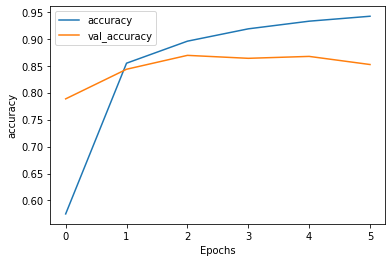

In [11]:
##### Graphs 
plot_graphs(fhist, 'accuracy')


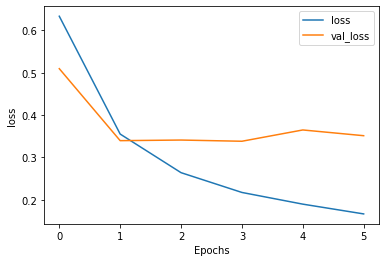

In [12]:
plot_graphs(fhist, 'loss')

# 5. Predict

In [16]:
def predict_sentiment(observation, pad=False):
    enc_observation = encoder.encode( observation )
    
    if pad:
        enc_observation = pad_to_size( enc_observation, 64)
        
    enc_observation = tf.cast( enc_observation, tf.float32 )
    
    pred = model.predict( tf.expand_dims(enc_observation, 0 ) )
    
    return pred

sample_reviews = [ "That was such a good movie!", "That was terribly good!", 
                  "That was such a good movie  ",
                  "That was such a bad movie!", "Amazing! How can something so bad be out there!"]


In [14]:
print("\n ==== NO PADDING ==== \n")
for s in sample_reviews:
    print("{} ===> {}".format(s, predict_sentiment(s) ) ) 
    
# print("\n ==== YES PADDING ==== \n")
# for s in sample_reviews:
#     print("{} ===> {}".format(s, predict_sentiment(s, pad=True) ) ) 


 ==== NO PADDING ==== 

That was such a good movie! ===> [[0.23156986]]
That was terribly good! ===> [[0.086781]]
That was such a bad movie! ===> [[-0.44894505]]
Amazing! How can something so bad be out there! ===> [[-0.62947047]]


# 6. Stack multiple LSTM layers

In [17]:
n_lsmz = 3

## create model
model = compile_2class_lstm_model( encoder.vocab_size, n_lstmz=n_lsmz)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          523840    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense (Dense)                (None, None, 64)          8256      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           6

In [15]:

## train model 
fhist = train_model(model, train_x)
print("\n{}\n".format( fhist ) )

## evaluate
test_loss, test_acc = model.evaluate( test_x )
print("\nWithout Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )

# test_loss, test_acc = model.evaluate( pad_to_size(test_x , 64) ) 
# print("\nWith Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )

## predict
print("\n ==== NO PADDING ==== \n")
for s in sample_reviews:
    print("{} ===> {}".format(s, predict_sentiment(s) ) ) 
    
# print("\n ==== YES PADDING ==== \n")
# for s in sample_reviews:
#     print("{} ===> {}".format(s, predict_sentiment(s, pad=True) ) ) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
dense_2 (Dense)              (None, None, 64)          8256      
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)          

INFO:tensorflow:Assets written to: IMDB_ltsm_model.rnn\assets



{'loss': [0.6766876460456848, 0.5159222217941284, 0.461657157535553, 0.5701415099525452, 0.44845341547966006, 0.4490867226791382, 0.5710107383728027], 'accuracy': [0.5261898, 0.73360693, 0.7908917, 0.65883595, 0.8208728, 0.8007513, 0.5921765], 'val_loss': [0.6237304192369856, 0.567897106299315, 0.48508222824167413, 0.5104231122509598, 0.42810333720253557, 0.6273691770060897, 0.5465202890241238], 'val_accuracy': [0.59151256, 0.5512017, 0.7810826, 0.80681336, 0.84136283, 0.56572855, 0.59038454]}

    175/Unknown - 2s 2s/step - loss: 0.5069 - accuracy: 0.65 - 5s 2s/step - loss: 0.5522 - accuracy: 0.57 - 7s 2s/step - loss: 0.5668 - accuracy: 0.58 - 10s 2s/step - loss: 0.5691 - accuracy: 0.580 - 13s 3s/step - loss: 0.5824 - accuracy: 0.587 - 15s 3s/step - loss: 0.5688 - accuracy: 0.588 - 18s 3s/step - loss: 0.5667 - accuracy: 0.596 - 21s 3s/step - loss: 0.5693 - accuracy: 0.591 - 23s 3s/step - loss: 0.5660 - accuracy: 0.592 - 26s 3s/step - loss: 0.5703 - accuracy: 0.595 - 28s 3s/step - los

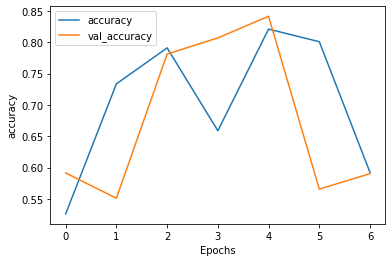

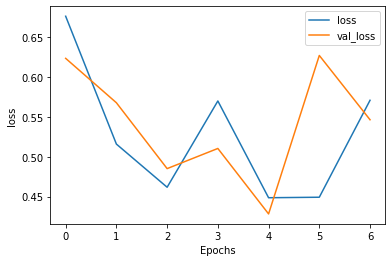

In [16]:
##### Graphs 
plot_graphs(fhist, 'accuracy')
plot_graphs(fhist, 'loss')

In [ ]:
## Let's check it out at 4 epochs where it seems to be at best performance
## train model 
fhist = train_model(model, train_x, epochs=4, test_epochs=1,)
print("\n{}\n".format( fhist ) )

## evaluate
test_loss, test_acc = model.evaluate( test_x )
print("\nWithout Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )

# test_loss, test_acc = model.evaluate( pad_to_size(test_x , 64) ) 
# print("\nWith Padding: loss = {} \taccuracy={}".format(test_loss, test_acc ) )

## predict
print("\n ==== NO PADDING ==== \n")
for s in sample_reviews:
    print("{} ===> {}".format(s, predict_sentiment(s) ) ) 
    

Epoch 1/4


In [ ]:
##### Graphs 
plot_graphs(fhist, 'accuracy')
plot_graphs(fhist, 'loss')